In [1]:
import torch
#import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm
import math

from processing_v2 import approx_distribution
from processing_v2 import get_samples, get_bias_list
#from Transformer_Model_LayerNorm import ViT
from Transformer_Model_neuron import ViT

In [2]:
import torch
import torchvision
import torchvision.transforms as tranforms
import matplotlib.pyplot as plt

mean = [0.5,0.5,0.5] #[0.4914672374725342, 0.4822617471218109, 0.4467701315879822]
std = [0.5,0.5,0.5] #[0.24703224003314972, 0.24348513782024384, 0.26158785820007324]

transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Normalize((mean[0],mean[1],mean[2]),
                                                        (std[0],std[1],std[2]))])
#trainset=torchvision.datasets.CIFAR10(root='./data',train=True, download=True, transform=transform)
trainset=torchvision.datasets.CIFAR10("~/.torch", download=True)
#trainloader=torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True)
mean = [0.5,0.5,0.5] #[0.4914672374725342, 0.4822617471218109, 0.4467701315879822]
std = [0.5,0.5,0.5] #[0.24703224003314972, 0.24348513782024384, 0.26158785820007324]

transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Normalize((mean[0],mean[1],mean[2]),
                                                        (std[0],std[1],std[2]))])
trainset=torchvision.datasets.CIFAR100(root='./data',train=True, download=True, transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True)
validset=torchvision.datasets.CIFAR100(root='./data',train=False, download=True, transform=transform)
validloader=torch.utils.data.DataLoader(validset,batch_size=32,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
#np.save("img_list.npy",np.array(img_index))

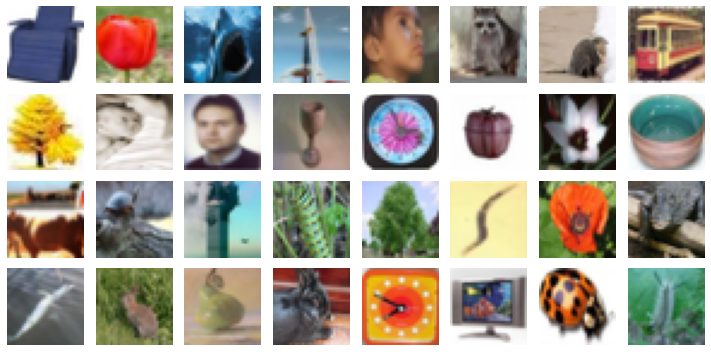

In [4]:

index=list(np.load("img_list.npy"))


image_list=[]
sum_pix=[]
label=[]
for i in range(len(index)):
    #img =data[i] #validloader.dataset[index[i]]
    img, label2 =trainloader.dataset[index[i]]
    image_list.append(img)
    label.append(label2)
    sum_pix.append(torch.sum(img[:,0:16,16:32]))
image_list=torch.stack(image_list)

mean_inv=torch.tensor(mean).reshape(3,1,1)
std_inv=torch.tensor(std).reshape(3,1,1)
def plot_images(images, rows, cols):
    images = images.clone().detach()
    images=(images*std_inv+mean_inv).clamp(0,1)

    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        #ax.imshow(images[i].transpose(1, 2, 0))
        #images[i]=images[i].reshape(3,32,32)
        ax.imshow(images[i].permute(1, 2, 0).cpu());
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(image_list,rows=4,cols=8)

In [5]:
RANDOM_SEED = 42
EPOCHS =  1 #40
LEARNING_RATE = 1e-4
NUM_CLASSES = 100
PATCH_SIZE = 16
IMG_SIZE = 32
CHANNELS = 3
global GLOBAL_VAR
GLOBAL_VAR=0
DROPOUT = 0 # 0.001
#HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 1

NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
PATCH_DIM = (PATCH_SIZE ** 2) * CHANNELS
EMBED_DIM = (PATCH_SIZE ** 2) * CHANNELS #* (NUM_PATCHES+1)
NUM_HEADS = 12 #NUM_PATCHES+1
HEAD_DIM= EMBED_DIM//NUM_HEADS
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cpu" if torch.cuda.is_available() else "cpu"

In [6]:

r=64 #125
model = ViT(r,EMBED_DIM, PATCH_DIM, PATCH_SIZE, NUM_PATCHES,NUM_HEADS, HEAD_DIM, DROPOUT, CHANNELS, NUM_CLASSES).to(device)

#x=image_list.reshape(batch_size,1,3,32,32)
x=image_list[0].reshape(1,1,3,32,32)
# #print(x)
print(x.shape)
print(model(x).shape)

print(model.parameters)

torch.Size([1, 1, 3, 32, 32])
torch.Size([1, 768])
torch.Size([1, 100])
<bound method Module.parameters of ViT(
  (patch): Create_Patch(
    (fc1): Linear(in_features=768, out_features=768, bias=False)
    (flat): Flatten(start_dim=1, end_dim=-1)
  )
  (mlphead): MLPHead(
    (head): Linear(in_features=768, out_features=100, bias=True)
  )
  (LN): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (encoder1): Encoder(
    (attn): Attention(
      (LN1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (QKV): Linear(in_features=768, out_features=2304, bias=True)
      (msa): Linear(in_features=768, out_features=768, bias=False)
      (adapt1): Linear(in_features=768, out_features=64, bias=True)
      (relu): ReLU()
      (adapt2): Linear(in_features=64, out_features=768, bias=True)
      (res): Residual()
    )
    (mlp): MLP(
      (LN2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (gelu)

In [7]:
w_glob=model.state_dict()
#print(w_glob.keys())
D=PATCH_DIM
coeff=0.5#32
E=coeff*torch.eye(D)
print(E)

tensor([[0.5000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5000]])


In [8]:
#print(w_glob.keys())

In [9]:
#data=dstp(dst[i][0])[:, 0:16, 0:16]
#print(data.shape)
# a=np.load("means.npy")
# print(a)
# b=np.load("sigmas.npy")
# print(b)
#d=32
d=20 #16
d2=64
#d2=0
w_glob['patch.position_embeddings'][:,:,0:d]=torch.zeros(w_glob['patch.position_embeddings'][:,:,0:d].size())
for i in range(w_glob['patch.position_embeddings'].shape[1]):
   mean1=torch.mean(w_glob['patch.position_embeddings'][0][i][d:])
   std=torch.std(w_glob['patch.position_embeddings'][0][i][d:])
   # mean=torch.mean(w_glob['patch.position_embeddings'][0][i])
   # std=torch.std(w_glob['patch.position_embeddings'][0][i])
   mean2=torch.mean(w_glob['patch.position_embeddings'][0][i][d:d2])
   std2=torch.std(w_glob['patch.position_embeddings'][0][i][d:d2])
   #w_glob['patch.position_embeddings'][0][i][d:d2]=(w_glob['patch.position_embeddings'][0][i][d:d2]-mean2)/std2
   #w_glob['patch.position_embeddings'][0][i][d:d2]=50*w_glob['patch.position_embeddings'][0][i][d:d2]
   # mean=0
   # std=1
   w_glob['patch.position_embeddings'][0][i][d:]=10*(w_glob['patch.position_embeddings'][0][i][d:]-mean1)/std
   #w_glob['patch.position_embeddings'][0][i]=50*(w_glob['patch.position_embeddings'][0][i]-mean)/std
   print(torch.mean( w_glob['patch.position_embeddings'][0][i]))
   print(torch.std( w_glob['patch.position_embeddings'][0][i]))

num_bins= 320 #256 #1408 #960 #704 #1125 #800 #750

tensor(-9.9341e-09)
tensor(9.8688)
tensor(1.6888e-07)
tensor(9.8688)
tensor(-6.9539e-08)
tensor(9.8688)
tensor(-1.1921e-07)
tensor(9.8688)
tensor(1.9868e-08)
tensor(9.8688)


In [11]:
multiplier=100 #3
scale=1
biases_patch=[[]]*(NUM_PATCHES+1)
distn=approx_distribution(dataset=validloader.dataset)

#Calculate the bins from public dataset

biases_patch[0]=torch.zeros(num_bins)

row1, row2, col1, col2=0, 16, 0, 16
mu1,sigma1 = distn.get_mean_std3(scale, row1, row2, col1, col2, w_glob['patch.position_embeddings'][0][1],E, multiplier)
print("done")
row1, row2, col1, col2=0, 16, 16, 32
mu2,sigma2 = distn.get_mean_std3(scale,row1,row2, col1, col2, w_glob['patch.position_embeddings'][0][2],E, multiplier)
print("done")
row1, row2, col1, col2=16, 32, 0, 16
mu3,sigma3 = distn.get_mean_std3(scale,row1,row2,col1,col2, w_glob['patch.position_embeddings'][0][3],E, multiplier)
print("done")
row1, row2, col1, col2=16, 32, 16, 32
mu4,sigma4 = distn.get_mean_std3(scale,row1,row2,col1,col2, w_glob['patch.position_embeddings'][0][4],E, multiplier)
print("done")



a=[]
a.append(mu1)
a.append(mu2)
a.append(mu3)
a.append(mu4)
np.save("means2.npy",np.array(a))
b=[]
b.append(sigma1)
b.append(sigma2)
b.append(sigma3)
b.append(sigma4)
np.save("sigmas2.npy",np.array(b))

a=np.load("means2.npy")
b=np.load("sigmas2.npy")

mu1,sigma1=a[0],b[0]
get_bias=get_bias_list(mu1,sigma1)
biases_patch[1], bin_width_patch1 = get_bias.create_bins(num_bins)

mu2,sigma2=a[1],b[1]
get_bias=get_bias_list(mu2,sigma2)
biases_patch[2], bin_width_patch2 = get_bias.create_bins(num_bins)

mu3,sigma3=a[2],b[2]
get_bias=get_bias_list(mu3,sigma3)
biases_patch[3], bin_width_patch3 = get_bias.create_bins(num_bins)

mu4,sigma4=a[3],b[3]
get_bias=get_bias_list(mu4,sigma4)
biases_patch[4], bin_width_patch4 = get_bias.create_bins(num_bins)




print("done")



done
done
done
done
done


In [12]:
import torch

# Set dimensions
m, n = r, EMBED_DIM


W1 = torch.zeros(m, n)
W1[:, :m] = torch.eye(m)
W2=torch.zeros(n,m)

W2[0:r] = W1[:, :m].T
print(W2.shape)

identity_matrix = W2 @ W1
print(identity_matrix.shape)



torch.Size([768, 64])
torch.Size([768, 768])


In [13]:

#Design the parameters

from Design_Model_Adapter import Design
#d=64
weight_first=4
weight=1
high=10000
All_PATCH=NUM_PATCHES+1
ENCODER_NO=12

gap=0 #5
malicious_model=Design(r,gap, d,num_bins, EMBED_DIM,PATCH_DIM,NUM_HEADS, NUM_PATCHES)
w_glob['patch.fc1.weight']=malicious_model.linear_embed(w_glob['patch.fc1.weight'], coeff)

w_glob['encoder1.attn.QKV.weight']=malicious_model.first_encoder(w_glob['encoder1.attn.QKV.weight'])
w_glob['encoder1.attn.adapt1.weight'], w_glob['encoder1.attn.adapt2.weight']=malicious_model.first_adapter(w_glob['encoder1.attn.adapt1.weight'],w_glob['encoder1.attn.adapt2.weight'], W1, W2)
#w_glob['encoder1.attn.adapt1.weight'][:,0:64]=0
w_glob['encoder1.attn.adapt1.bias']=high*torch.ones(w_glob['encoder1.attn.adapt1.bias'].size())
w_glob['encoder1.attn.adapt2.bias']=-W2@w_glob['encoder1.attn.adapt1.bias']
target=1
w_glob['encoder1.attn.QKV.bias'][0:HEAD_DIM]=10**6*w_glob['patch.position_embeddings'][:,target,0:HEAD_DIM].reshape(HEAD_DIM)
w_glob['encoder1.attn.QKV.bias'][HEAD_DIM:]=torch.zeros(w_glob['encoder1.attn.QKV.bias'][HEAD_DIM:].size())
w_glob['encoder1.attn.msa.weight']= weight_first*torch.eye(EMBED_DIM)

start=0
r2=start

patch_id=1
count=0
for i in range(1,12): #ENCODER_NO):
#     print("break")
#     print("patch_id", patch_id)


    key1=f'encoder{i}.mlp.fc1.weight'
    w_glob[key1]=malicious_model.mlp_identity(w_glob[key1])

    key2=f'encoder{i}.mlp.fc2.weight'
    w_glob[key2]=malicious_model.mlp_identity(w_glob[key2])

    key3=f'encoder{i}.mlp.fc1.bias'
    w_glob[key3]=torch.zeros(w_glob[key3].size())
    w_glob[key3][0:EMBED_DIM]=high*torch.ones(w_glob[key3][0:EMBED_DIM].size())

    key4=f'encoder{i}.mlp.fc2.bias'
    #w_glob[key4]=torch.zeros(w_glob[key4].size())
    w_glob[key4]=-high*torch.ones(w_glob[key4].size())

    E_pos_mean=torch.mean(w_glob['patch.position_embeddings'][:,1])
    E_pos_std=torch.std(w_glob['patch.position_embeddings'][:,2])
    key5=f'encoder{i}.attn.LN1.weight'
    w_glob[key5]=E_pos_std*torch.ones(w_glob[key5].size())

    key6=f'encoder{i}.mlp.LN2.weight'
    w_glob[key6]=E_pos_std*torch.ones(w_glob[key6].size())

    #patch_id=4

    key7=f'encoder{i}.mlp.adapt1.weight'
    w_glob[key7]=malicious_model.adapter(w_glob[key7], w_glob['patch.position_embeddings'][0],patch_id, multiplier)
    w_glob[key7][:,0:64]=0

    key8=f'encoder{i}.mlp.adapt2.weight'
    w_glob[key8]=torch.zeros(w_glob[key8].size())
    w_glob[key8][-1]=10**(-6)/w_glob[key8].shape[1]

    key9=f'encoder{i}.mlp.adapt2.bias'
    w_glob[key9]=torch.zeros(w_glob[key9].size())



    if i>1:
        key10=f'encoder{i}.attn.adapt1.weight'
        w_glob[key10]=malicious_model.adapter(w_glob[key10], w_glob['patch.position_embeddings'][0],patch_id, multiplier)
        w_glob[key10][:,0:64]=0

        key11=f'encoder{i}.attn.adapt2.weight'
        w_glob[key11]=torch.zeros(w_glob[key11].size())
        w_glob[key11][-1]=10**(-6)/w_glob[key11].shape[1]

        key12=f'encoder{i}.attn.adapt2.bias'
        w_glob[key12]=torch.zeros(w_glob[key12].size())

        key13=f'encoder{i}.attn.QKV.weight'
        w_glob[key13]=malicious_model.attention(w_glob[key13])

        key14=f'encoder{i}.attn.QKV.bias'
        w_glob[key14]=torch.zeros(w_glob[key14].size())

        key15=f'encoder{i}.attn.msa.weight'
        w_glob[key15]=weight*torch.eye(EMBED_DIM)

    if i>1:
        r1=r2 #+gap
        r2+=r-gap
#         print("MSA")
#         print(r1)
#         print(r2)
        key18=f'encoder{i}.attn.adapt1.weight'
        key19=f'encoder{i}.attn.adapt1.bias'
        w_glob[key19][gap:r]=-w_glob[key18][gap].T@(w_glob['patch.position_embeddings'][0][patch_id])-biases_patch[patch_id][r1:r2]
        count+=1
        if count==5:
            #print("Hurrah1")
            if patch_id<4:
                patch_id+=1
            r2=start
            count=0
    r1=r2 #+gap
    r2+=r-gap
#     print("MLP")
#     print(r1)
#     print(r2)
    key16=f'encoder{i}.mlp.adapt1.weight'
    key17=f'encoder{i}.mlp.adapt1.bias'
    high_dot=w_glob[key16][gap].T@(high*torch.ones(w_glob[key16][gap].size()))
    #w_glob[key17][gap:r]=-high_dot-w_glob[key16][gap].T@(w_glob['patch.position_embeddings'][0][patch_id])-biases_patch[patch_id][r1:r2]
    w_glob[key17][gap:r]=-w_glob[key16][gap].T@(w_glob['patch.position_embeddings'][0][patch_id])-biases_patch[patch_id][r1:r2]

    count+=1
    if count==5:
        #print("Hurrah2")
        if patch_id<4:
            patch_id+=1
        r2=start
        count=0


<ipython-input-13-a857738b3684>:116: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  high_dot=w_glob[key16][gap].T@(high*torch.ones(w_glob[key16][gap].size()))


In [14]:
GLOBAL_VAR=0
model.load_state_dict(w_glob)

<All keys matched successfully>

In [15]:
#Compute gradient in the adapter layers
GLOBAL_VAR=0
import copy
batch_size=32 #48
y=label[0:batch_size] #.reshape(1)
y=torch.tensor(y)
print(type(y))
#y=torch.tensor(trainloader.dataset[index[16]][1])
print(y)
#y=y.reshape(1)
#print(y)
criterion=nn.CrossEntropyLoss()
w_prev=copy.deepcopy(model.state_dict())
optimizer=optim.SGD(model.parameters(), lr=0.001)
#optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)  # Optimizer only updates parameters with requires_grad=True

for name, param in model.named_parameters():
    if 'adapt1' in name or 'adapt2'  in name:   # Replace 'layer_name' with the specific layers you want gradients for
        param.requires_grad = True
    else:
        param.requires_grad = False
iter=1

data=image_list[0:batch_size].reshape(batch_size,1,3,32,32)
#y=label.reshape(1)
for i in range(iter):

    model.train()
    model.zero_grad()
    output=model(data)
    loss=criterion(output.to(device),y.to(device))
    #optimizer.zero_grad()
    loss.backward()
    #optimizer.step() #used to update model parameters
    print(loss)



<class 'torch.Tensor'>
tensor([25, 92, 73, 76, 11, 66, 64, 81, 47,  2, 46, 28, 22, 83, 92, 10, 19, 93,
        76, 18, 47, 99, 62, 27, 73, 65, 57, 65, 22, 87,  7, 18])
torch.Size([32, 768])
tensor(4.5963, grad_fn=<NllLossBackward0>)


In [16]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name)

encoder1.attn.adapt1.weight
encoder1.attn.adapt1.bias
encoder1.attn.adapt2.weight
encoder1.attn.adapt2.bias
encoder1.mlp.adapt1.weight
encoder1.mlp.adapt1.bias
encoder1.mlp.adapt2.weight
encoder1.mlp.adapt2.bias
encoder2.attn.adapt1.weight
encoder2.attn.adapt1.bias
encoder2.attn.adapt2.weight
encoder2.attn.adapt2.bias
encoder2.mlp.adapt1.weight
encoder2.mlp.adapt1.bias
encoder2.mlp.adapt2.weight
encoder2.mlp.adapt2.bias
encoder3.attn.adapt1.weight
encoder3.attn.adapt1.bias
encoder3.attn.adapt2.weight
encoder3.attn.adapt2.bias
encoder3.mlp.adapt1.weight
encoder3.mlp.adapt1.bias
encoder3.mlp.adapt2.weight
encoder3.mlp.adapt2.bias
encoder4.attn.adapt1.weight
encoder4.attn.adapt1.bias
encoder4.attn.adapt2.weight
encoder4.attn.adapt2.bias
encoder4.mlp.adapt1.weight
encoder4.mlp.adapt1.bias
encoder4.mlp.adapt2.weight
encoder4.mlp.adapt2.bias
encoder5.attn.adapt1.weight
encoder5.attn.adapt1.bias
encoder5.attn.adapt2.weight
encoder5.attn.adapt2.bias
encoder5.mlp.adapt1.weight
encoder5.mlp.adap

In [17]:
#scale=4
import time
start=time.time()
weight_grad=[]
bias_grad=[]
from recover_adapter import reconstruct
for name, param in model.named_parameters():
    if ( name=='encoder1.mlp.adapt1.weight' or
     name=='encoder2.attn.adapt1.weight' or name=='encoder2.mlp.adapt1.weight' or
     name=='encoder3.attn.adapt1.weight' or name=='encoder3.mlp.adapt1.weight' or
       name=='encoder4.attn.adapt1.weight' or name=='encoder4.mlp.adapt1.weight' or
       name=='encoder5.attn.adapt1.weight' or name=='encoder5.mlp.adapt1.weight' or
       name=='encoder6.attn.adapt1.weight' or name=='encoder6.mlp.adapt1.weight' or
       name=='encoder7.attn.adapt1.weight' or name=='encoder7.mlp.adapt1.weight' or
       name=='encoder8.attn.adapt1.weight' or name=='encoder8.mlp.adapt1.weight' or
       name=='encoder9.attn.adapt1.weight' or name=='encoder9.mlp.adapt1.weight' or
       name=='encoder10.attn.adapt1.weight' or name=='encoder10.mlp.adapt1.weight' or
       name=='encoder11.attn.adapt1.weight' or name=='encoder11.mlp.adapt1.weight'):
        #print(name)
        weight_grad.append(param.grad)
    if ( name == 'encoder1.mlp.adapt1.bias' or
     name=='encoder2.attn.adapt1.bias' or name == 'encoder2.mlp.adapt1.bias' or
     name=='encoder3.attn.adapt1.bias' or name == 'encoder3.mlp.adapt1.bias' or
       name=='encoder4.attn.adapt1.bias' or name == 'encoder4.mlp.adapt1.bias' or
       name=='encoder5.attn.adapt1.bias' or name == 'encoder5.mlp.adapt1.bias' or
       name=='encoder6.attn.adapt1.bias' or name=='encoder6.mlp.adapt1.bias' or
       name=='encoder7.attn.adapt1.bias' or name=='encoder7.mlp.adapt1.bias' or
       name=='encoder8.attn.adapt1.bias' or name=='encoder8.mlp.adapt1.bias' or
       name=='encoder9.attn.adapt1.bias' or name=='encoder9.mlp.adapt1.bias' or
       name=='encoder10.attn.adapt1.bias' or name=='encoder10.mlp.adapt1.bias' or
       name=='encoder11.attn.adapt1.bias' or name=='encoder11.mlp.adapt1.bias'):
        bias_grad.append(param.grad)
#patch_id=2
block=2*(ENCODER_NO-1)-1
#recons=reconstruct(gap,block,high, num_bins, weight_grad, bias_grad, patch_id,patch_id,  std_inv, mean_inv,w_glob['patch.position_embeddings'][0],coeff)

32


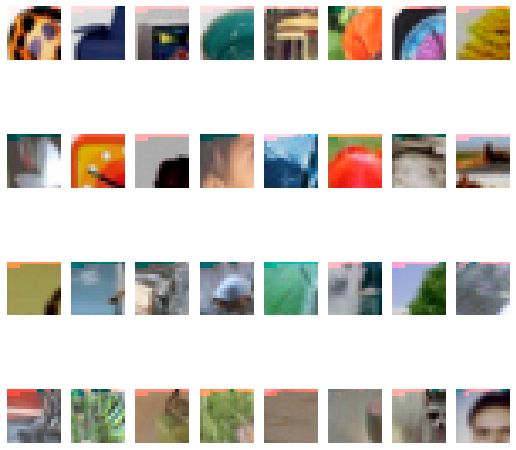

In [18]:
patch_id=1
block=5
#recover Patches from Position 1
recons1=reconstruct(gap,block,high, num_bins, weight_grad[0:5], bias_grad[0:5], patch_id,patch_id,  std_inv, mean_inv,w_glob['patch.position_embeddings'][0],coeff)


31


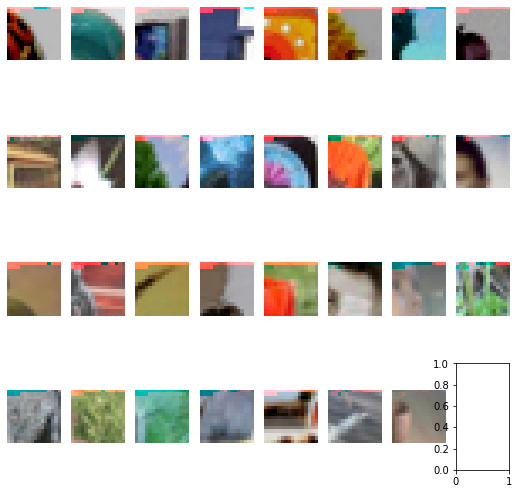

In [19]:
#recover Patches from Position 2
patch_id=2
block=5
recons2=reconstruct(gap,block,high, num_bins, weight_grad[5:10], bias_grad[5:10], patch_id,patch_id,  std_inv, mean_inv,w_glob['patch.position_embeddings'][0],coeff)

30


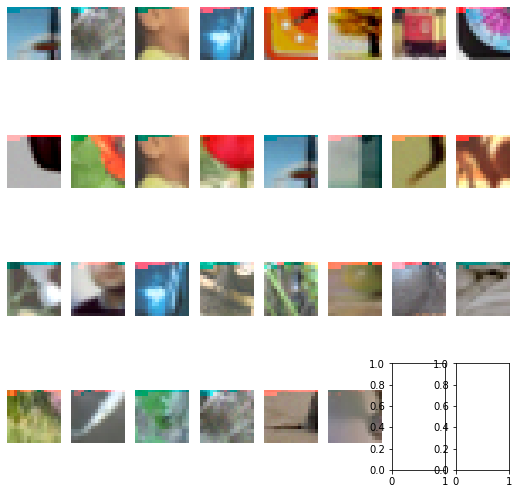

In [20]:
#recover Patches from Position 3
patch_id=3
block=5
recons3=reconstruct(gap,block,high, num_bins, weight_grad[10:15], bias_grad[10:15], patch_id,patch_id,  std_inv, mean_inv,w_glob['patch.position_embeddings'][0],coeff)


31


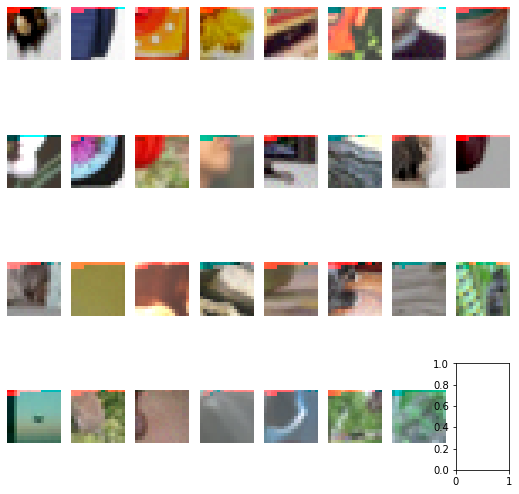

In [21]:
#recover Patches from Position 4
patch_id=4
block=5
recons4=reconstruct(gap, block,high, num_bins, weight_grad[15:20], bias_grad[15:20], patch_id,patch_id,  std_inv, mean_inv,w_glob['patch.position_embeddings'][0],coeff)


In [22]:
from Clustering import match_cluster
import time
start=time.time()
cluster_comp=[]
center=[]
#batch_size=48
for i in range(len(recons1)):
    cluster_comp.append(recons1[i].reshape(768)[0:d])
    center.append(recons1[i].reshape(768)[0:d])
for i in range(len(recons2)):
    cluster_comp.append(recons2[i].reshape(768)[0:d])
for i in range(len(recons3)):
    cluster_comp.append(recons3[i].reshape(768)[0:d])
for i in range(len(recons4)):
    cluster_comp.append(recons4[i].reshape(768)[0:d])
print(len(cluster_comp))
cluster_index=match_cluster(torch.stack(cluster_comp), batch_size, NUM_PATCHES)
#cluster_index=match_cluster_center(center, torch.stack(cluster_comp), 64, NUM_PATCHES)
print(cluster_index)
end=time.time()
print(end-start)

124
tensor([ 5,  6,  2, 29, 13,  7, 10, 31, 11,  9, 21, 19,  8, 15, 14, 22,  1, 24,
         0,  4, 18,  3, 23, 30, 27, 12, 26, 28, 17, 20,  8, 25,  5, 29,  2,  6,
         9, 31,  3, 21, 13, 11, 23, 16, 10,  7,  8, 25, 26, 27,  1, 17, 15, 14,
        24, 12,  0, 28, 18,  4, 22, 30, 20, 24,  4, 19, 16,  9, 31, 13, 10, 21,
         7, 19, 15, 24,  3,  1, 22, 11, 25, 16,  0, 12, 26, 27, 14, 28, 30, 18,
         4, 17, 20,  5,  6,  9, 31, 13,  7, 25, 29, 11, 10, 15, 19,  2, 30, 17,
        21,  8,  1, 23,  0, 26, 27, 14, 12,  3, 28, 20, 22, 16, 23, 18])
0.6279881000518799


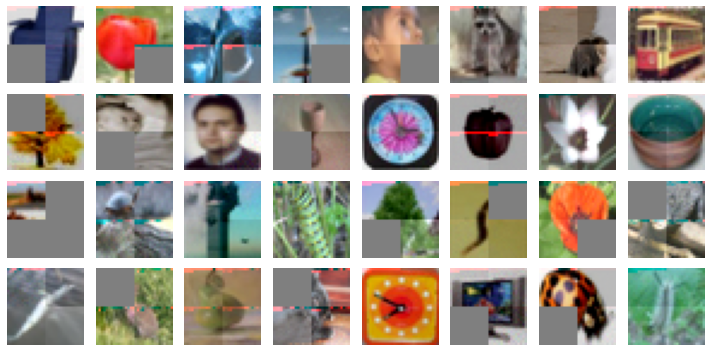

In [23]:
#torch.save(final,"CIFAR100_32images.pt")
a=torch.load("CIFAR100_32images_final_sorted.pt")
plot_images(a, rows=4, cols=8)

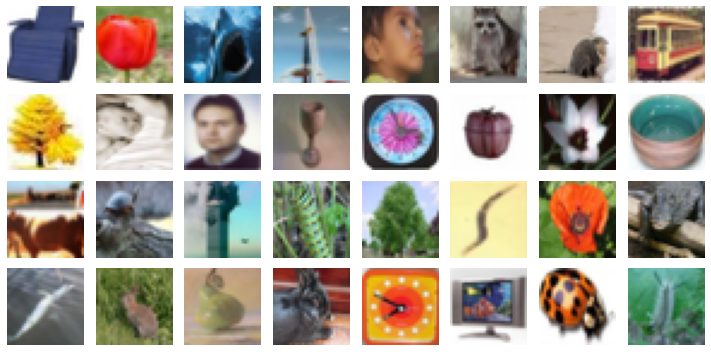

In [24]:
plot_images(image_list,rows=4,cols=8)